In [86]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_niblack, threshold_sauvola
from scipy.ndimage import distance_transform_edt

In [87]:
import kagglehub

path = kagglehub.dataset_download(
    "andrewmvd/drive-digital-retinal-images-for-vessel-extraction"
)

image_dir = f"{path}/DRIVE/training/images"
gt_dir    = f"{path}/DRIVE/training/1st_manual"
fov_dir   = f"{path}/DRIVE/training/mask"

img_files = sorted(os.listdir(image_dir))
gt_files  = sorted(os.listdir(gt_dir))
fov_files = sorted(os.listdir(fov_dir))

print(len(img_files), "images loaded")

20 images loaded


In [88]:
def sensitivity(pred, gt):

    TP = np.sum((pred == 1) & (gt == 1))
    FN = np.sum((pred == 0) & (gt == 1))

    return TP / (TP + FN + 1e-8)

In [89]:
def extract_thin_vessels(gt):

    dist = distance_transform_edt(gt)
    thin = ((gt == 1) & (dist <= 1.5)).astype(np.uint8)

    return thin

In [90]:
def preprocess(img):

    green = img[:, :, 1]     

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    green = clahe.apply(green)

    return green

In [91]:
window_size = 35
k_niblack   = -0.2
k_sauvola   = 0.3
R_value     = 60

In [92]:
sens_niblack = []
sens_sauvola = []

for i in range(len(img_files)):

    img = cv2.imread(os.path.join(image_dir, img_files[i]))
    gt  = cv2.imread(os.path.join(gt_dir, gt_files[i]), 0)
    fov = cv2.imread(os.path.join(fov_dir, fov_files[i]), 0)

    img_p = preprocess(img)

    gt  = (gt  > 0).astype(np.uint8)
    fov = (fov > 0).astype(np.uint8)

    thr_n = threshold_niblack(img_p, window_size=window_size, k=k_niblack)
    thr_s = threshold_sauvola(img_p, window_size=window_size, k=k_sauvola, r=R_value)

    pred_n = (img_p < thr_n).astype(np.uint8) * fov
    pred_s = (img_p < thr_s).astype(np.uint8) * fov

    thin_gt = extract_thin_vessels(gt * fov)

    sens_niblack.append(sensitivity(pred_n, thin_gt))
    sens_sauvola.append(sensitivity(pred_s, thin_gt))

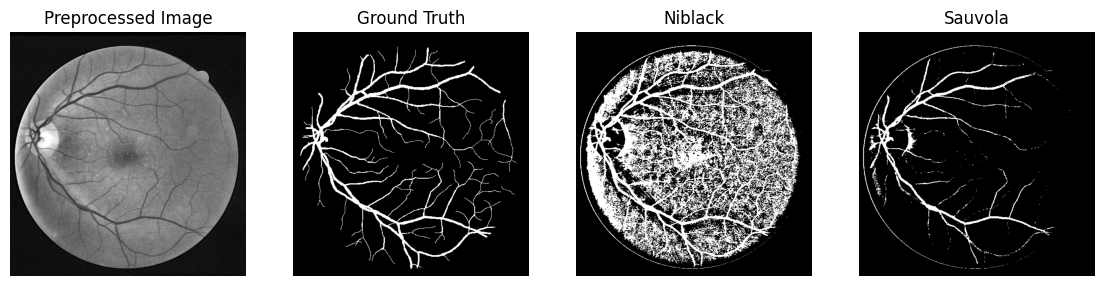

In [93]:
img = cv2.imread(os.path.join(image_dir, img_files[0]))
gt  = cv2.imread(os.path.join(gt_dir, gt_files[0]), 0)
fov = cv2.imread(os.path.join(fov_dir, fov_files[0]), 0)

img_p = preprocess(img)

gt  = (gt  > 0).astype(np.uint8)
fov = (fov > 0).astype(np.uint8)

thr_n = threshold_niblack(img_p, window_size=window_size, k=k_niblack)
thr_s = threshold_sauvola(img_p, window_size=window_size, k=k_sauvola, r=R_value)

nb = (img_p < thr_n).astype(np.uint8) * fov
sv = (img_p < thr_s).astype(np.uint8) * fov

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(img_p, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(nb, cmap='gray')
plt.title("Niblack")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(sv, cmap='gray')
plt.title("Sauvola")
plt.axis('off')

plt.show()